In [1]:
# Library imports.
from datetime import datetime
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import plotly.express as px
import numpy as np
import numpy.random as nprnd
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.linear_model import LinearRegression
import time

# Local imports.
from urbansurge import swmm_model, analysis_tools, file_utils

## Nominal System

### Physical system data.

In [58]:
# Links where state variables are measured.
sensor_links = [33, 49, 21, 55]

In [60]:
# Load in physical system data.
phy_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\physical_ramp_1.2in_n20_60min.csv"
phy_df = pd.read_csv(phy_fp)

# Datetimes.
phy_df['datetime'] = pd.to_datetime(phy_df['datetime'])

# True precipitation.
phy_prcp_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\impulse_ramp_1.2in_n20_60min.dat"
phy_prcp_df = pd.read_csv(phy_prcp_fp, sep='\s+', header=None)
phy_prcp = phy_prcp_df.iloc[:,2].to_numpy()
phy_date = phy_prcp_df.iloc[:,0].to_numpy()
phy_time = phy_prcp_df.iloc[:,1].to_numpy()

# True state variables.
phy_depth = phy_df.loc[:,[f'Depth_link_{i}' for i in sensor_links]].to_numpy()
phy_velocity = phy_df.loc[:,[f'Velocity_link_{i}' for i in sensor_links]].to_numpy()
phy_flow = phy_df.loc[:,[f'Flow_link_{i}' for i in sensor_links]].to_numpy()

### Measurement data

In [244]:
# Precipitation measurement: add noise to true precipitation.
meas_prcp_sdev = 0.1
meas_prcp = phy_prcp + np.random.normal(0, meas_prcp_sdev, len(phy_prcp)) * phy_prcp
meas_prcp[phy_prcp == 0] = 0 # No noise at 0 precipitation.

# Add noise to state variables.
meas_state_sdev = 0
meas_depth = phy_depth + np.random.normal(0, meas_state_sdev, phy_depth.shape)
meas_velocity = phy_velocity + np.random.normal(0, meas_state_sdev, phy_velocity.shape)
meas_flow = phy_flow + np.random.normal(0, meas_state_sdev, phy_flow.shape)

# Physicality constraints.
meas_depth[meas_depth < 0] = 0
meas_velocity[meas_velocity < 0] = 0
meas_flow[meas_flow < 0] = 0

### Modeled States

In [245]:
# Model instantiation.

# Path to configuration file.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 23:00:00


In [246]:
# Add precip to model.
ts_name = 'Measured'
ts_description = 'Measured Precipitation'
raingage_id = 1
swmm.add_prcp_timeseries(ts_name, ts_description, phy_time, meas_prcp, dates=phy_date, overwrite=True)
swmm.set_raingage_timeseries(raingage_id, ts_name)

# Run the model.
swmm.run_simulation()

# Get link depth.
link_depth_df = swmm.get_link_depth()

# Get link velocity.
link_velocity_df = swmm.get_link_velocity()

# Get link flow.
link_flow_df = swmm.get_link_flow()

# Extract the state variables at sensor locations.
mod_depth = link_depth_df.loc[:,[f'Depth_link_{j}' for j in sensor_links]].to_numpy()
mod_velocity = link_velocity_df.loc[:,[f'Velocity_link_{j}' for j in sensor_links]].to_numpy()
mod_flow = link_flow_df.loc[:,[f'Flow_link_{j}' for j in sensor_links]].to_numpy()

# Precipitation used to drive the model.
mod_prcp_df = swmm.get_rainfall_timeseries()
mod_prcp = mod_prcp_df['prcp'].to_numpy()

INP PATH: C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_tmp.inp
2020-01-01 00:00:01 , 0
2020-01-01 00:16:41 , 1
2020-01-01 00:33:21 , 2
2020-01-01 00:50:01 , 4
2020-01-01 01:06:41 , 5
2020-01-01 01:23:21 , 6
2020-01-01 01:40:01 , 7
2020-01-01 01:56:41 , 8
2020-01-01 02:13:21 , 10
2020-01-01 02:30:01 , 11
2020-01-01 02:46:41 , 12
2020-01-01 03:03:21 , 13
2020-01-01 03:20:01 , 14
2020-01-01 03:36:41 , 16
2020-01-01 03:53:21 , 17
2020-01-01 04:10:01 , 18
2020-01-01 04:26:41 , 19
2020-01-01 04:43:21 , 21
2020-01-01 05:00:01 , 22
2020-01-01 05:16:41 , 23
2020-01-01 05:33:21 , 24
2020-01-01 05:50:01 , 25
2020-01-01 06:06:41 , 27
2020-01-01 06:23:21 , 28
2020-01-01 06:40:01 , 29
2020-01-01 06:56:41 , 30
2020-01-01 07:13:21 , 31
2020-01-01 07:30:01 , 33
2020-01-01 07:46:41 , 34
2020-01-01 08:03:21 , 35
2020-01-01 08:20:01 , 36
2020-01-01 08:36:41 , 37
2020-01-01 08:53:21 , 39
2020-01-01 09:10:01 , 40
2020-01-01 09:26:41 , 41
2020-01-01 09:43:21 , 42
2020-01-01 10:00:01 , 4

### Compute residuals.

In [247]:
# Depth residuals.
res_depth = mod_depth - meas_depth
res_velocity = mod_velocity - meas_velocity
res_flow = mod_flow - meas_flow

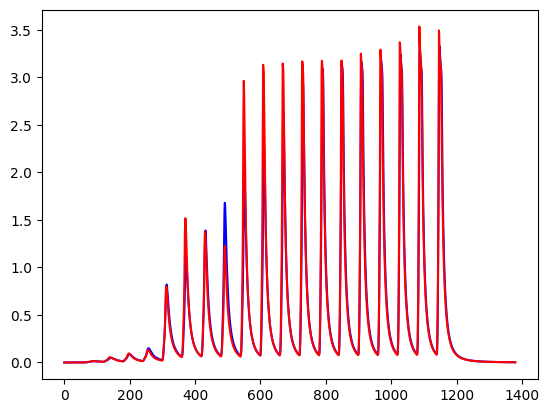

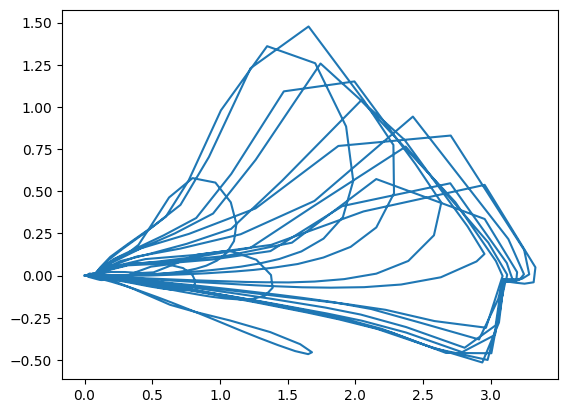

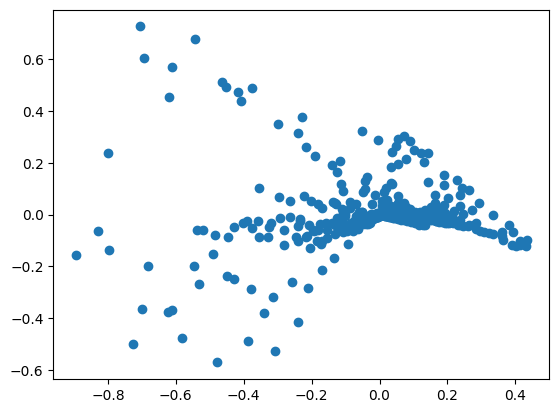

In [248]:
# Plot residuals.
sensor_idx = 0
fig, ax = plt.subplots()
ax.plot(meas_flow[:,sensor_idx], c='b')
ax.plot(mod_flow[:,sensor_idx], c='r')
# ax.axline([0, 0], slope=1, c='r')

fig, ax = plt.subplots()
ax.plot(meas_flow[:,sensor_idx], res_flow[:,sensor_idx])

fig, ax = plt.subplots()
ax.scatter(meas_flow[:-1,sensor_idx] - meas_flow[1:,sensor_idx], res_flow[:-1,sensor_idx] - res_flow[1:,sensor_idx])

## Fault System.

In [250]:
# Load in physical system data.
fault_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\roughness_54_unif_1in_n20_60min.csv"
fault_df = pd.read_csv(fault_fp)

# Datetimes.
fault_df['datetime'] = pd.to_datetime(fault_df['datetime'])

# Fault value.
fault_values = list(set(fault_df['fault_value']))
fault_values.sort()
fault_value = fault_values[10]
print(fault_value)

# Fault precip.
fault_prcp_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\impulse_unif_1in_n20_60min.dat"
fault_prcp_df = pd.read_csv(fault_prcp_fp, sep='\s+', header=None)
fault_prcp = fault_prcp_df.iloc[:,2].to_numpy()
fault_date = fault_prcp_df.iloc[:,0].to_numpy()
fault_time = fault_prcp_df.iloc[:,1].to_numpy()

# True fault state variables.
fault_depth = fault_df.loc[fault_df['fault_value']==fault_value, [f'Depth_link_{i}' for i in sensor_links]].to_numpy()
fault_velocity = fault_df.loc[fault_df['fault_value']==fault_value, [f'Velocity_link_{i}' for i in sensor_links]].to_numpy()
fault_flow = fault_df.loc[fault_df['fault_value']==fault_value, [f'Flow_link_{i}' for i in sensor_links]].to_numpy()

# Add noise to state variables.
meas_state_sdev = 0.0
fault_meas_depth = fault_depth + np.random.normal(0, meas_state_sdev, fault_depth.shape)
fault_meas_velocity = fault_velocity + np.random.normal(0, meas_state_sdev, fault_velocity.shape)
fault_meas_flow = fault_flow + np.random.normal(0, meas_state_sdev, fault_flow.shape)

# Physicality constraints.
fault_meas_depth[fault_meas_depth < 0] = 0
fault_meas_velocity[fault_meas_velocity < 0] = 0
fault_meas_flow[fault_meas_flow < 0] = 0

0.0234210526315789


### Measurement data.

In [251]:
# Precipitation measurement: add noise to true precipitation.
meas_fault_prcp_sdev = 0.0
meas_fault_prcp = fault_prcp + np.random.normal(0, meas_fault_prcp_sdev, len(fault_prcp)) * fault_prcp
meas_fault_prcp[meas_fault_prcp < 0] = 0 # No noise at 0 precipitation.

### Model with fault precip.

In [252]:
# Model instantiation.

# Path to configuration file.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 23:00:00


In [253]:
# Add precip to model.
ts_name = 'Measured'
ts_description = 'Measured Precipitation'
raingage_id = 1
swmm.add_prcp_timeseries(ts_name, ts_description, fault_time, meas_fault_prcp, dates=fault_date, overwrite=True)
swmm.set_raingage_timeseries(raingage_id, ts_name)

# Run the model.
swmm.run_simulation()

# Get link depth.
link_depth_df = swmm.get_link_depth()

# Get link velocity.
link_velocity_df = swmm.get_link_velocity()

# Get link flow.
link_flow_df = swmm.get_link_flow()

# Extract the state variables at sensor locations.
fault_mod_depth = link_depth_df.loc[:,[f'Depth_link_{j}' for j in sensor_links]].to_numpy()
fault_mod_velocity = link_velocity_df.loc[:,[f'Velocity_link_{j}' for j in sensor_links]].to_numpy()
fault_mod_flow = link_flow_df.loc[:,[f'Flow_link_{j}' for j in sensor_links]].to_numpy()

# Precipitation used to drive the model.
mod_prcp_df = swmm.get_rainfall_timeseries()
fault_mod_prcp = mod_prcp_df['prcp'].to_numpy()

INP PATH: C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_tmp.inp
2020-01-01 00:00:01 , 0
2020-01-01 00:16:41 , 1
2020-01-01 00:33:21 , 2
2020-01-01 00:50:01 , 4
2020-01-01 01:06:41 , 5
2020-01-01 01:23:21 , 6
2020-01-01 01:40:01 , 7
2020-01-01 01:56:41 , 8
2020-01-01 02:13:21 , 10
2020-01-01 02:30:01 , 11
2020-01-01 02:46:41 , 12
2020-01-01 03:03:21 , 13
2020-01-01 03:20:01 , 14
2020-01-01 03:36:41 , 16
2020-01-01 03:53:21 , 17
2020-01-01 04:10:01 , 18
2020-01-01 04:26:41 , 19
2020-01-01 04:43:21 , 21
2020-01-01 05:00:01 , 22
2020-01-01 05:16:41 , 23
2020-01-01 05:33:21 , 24
2020-01-01 05:50:01 , 25
2020-01-01 06:06:41 , 27
2020-01-01 06:23:21 , 28
2020-01-01 06:40:01 , 29
2020-01-01 06:56:41 , 30
2020-01-01 07:13:21 , 31
2020-01-01 07:30:01 , 33
2020-01-01 07:46:41 , 34
2020-01-01 08:03:21 , 35
2020-01-01 08:20:01 , 36
2020-01-01 08:36:41 , 37
2020-01-01 08:53:21 , 39
2020-01-01 09:10:01 , 40
2020-01-01 09:26:41 , 41
2020-01-01 09:43:21 , 42
2020-01-01 10:00:01 , 4

### Fault residuals.

In [254]:
# Depth residuals.
fault_res_depth = fault_mod_depth - fault_meas_depth
fault_res_velocity = fault_mod_velocity - fault_meas_velocity
fault_res_flow = fault_mod_flow - fault_meas_flow

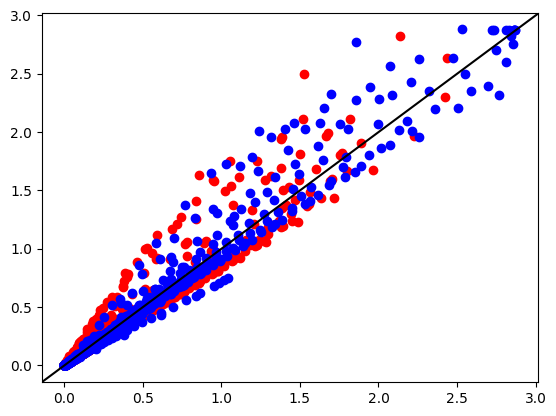

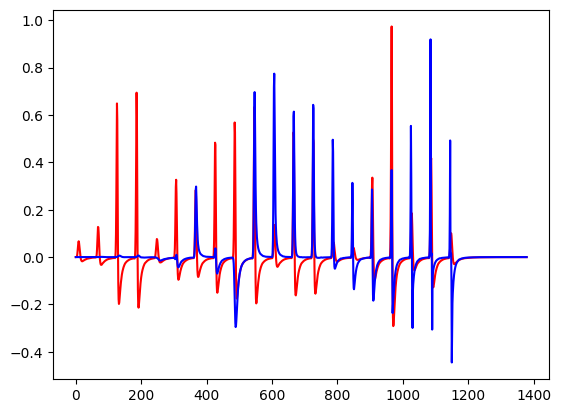

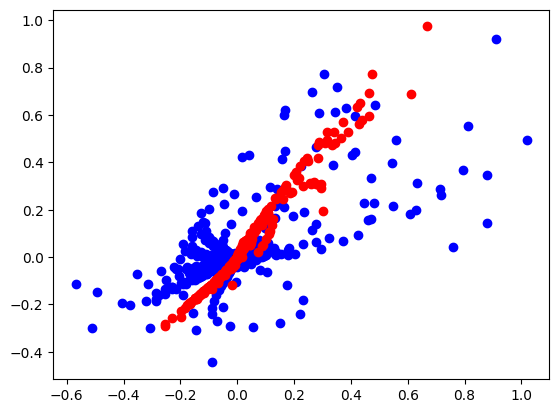

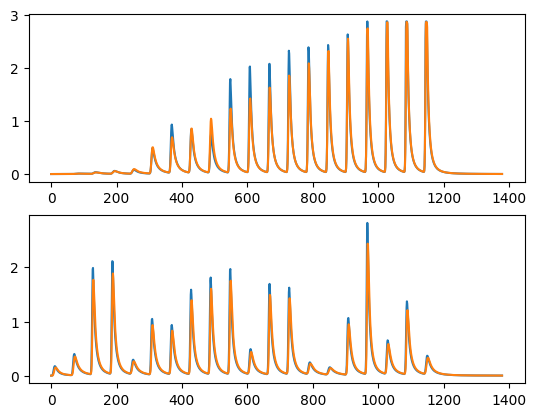

In [255]:
# Plot residuals.
sensor_idx = 3
fig, ax = plt.subplots()
ax.scatter(fault_meas_flow[:,sensor_idx], fault_mod_flow[:,sensor_idx], c='r')
ax.scatter(meas_flow[:,sensor_idx], mod_flow[:,sensor_idx], c='b')
ax.axline([0, 0], slope=1, c='k')

fig, ax = plt.subplots()
ax.plot(fault_res_flow[:, sensor_idx], c='r')
ax.plot(res_flow[:, sensor_idx], c='b')

fig, ax = plt.subplots()
ax.scatter((meas_flow[1:, sensor_idx] - meas_flow[:-1, sensor_idx]), 
           res_flow[1:, sensor_idx], c='b')
ax.scatter((fault_meas_flow[1:, sensor_idx] - fault_meas_flow[:-1, sensor_idx]), fault_res_flow[1:, sensor_idx], c='r')

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(mod_flow[:, sensor_idx])
ax1.plot(meas_flow[:, sensor_idx])

ax2.plot(fault_mod_flow[:, sensor_idx])
ax2.plot(fault_meas_flow[:, sensor_idx])

In [257]:
def lag_array(X, tau, NL):
    """
    :param X: 1D vector to lag.
    :param tau: Number of time steps to lag by.
    :param NL: Number of lagged time series.
    The function will maximize the length (L) of each lagged time series to fit the tau and NL constraints.
    
    return: Lagged array (L x NL) where each column is lagged by tau.
    """
    Nt = len(X)
    L = Nt - (NL - 1) * tau
    
    Xlag = np.zeros((L, NL))
    for i in range(NL):
        Xlag[:, i] = X[tau*i:tau*i + L]
        
    return Xlag


def lag_array_2d(X, tau, NL):
    """
    :param X: 2D vector to lag. Lag applied to columns of X.
    :param tau: Number of time steps to lag by.
    :param NL: Number of lagged time series.
    The function will maximize the length (L) of each lagged time series to fit the tau and NL constraints.
    
    return: Lagged array (L x X.shape[1] x NL) where each 3rd-dim slice is lagged by tau.
    """
    Nt = X.shape[0]
    Nc = X.shape[1]
    L = Nt - (NL - 1) * tau
    
    Xlag = np.zeros((L, Nc, NL))
    for c in range(Nc):
#         Xlag_c = np.zeros((L, NL))
#         for i in range(NL):
#             Xlag_c[:, i] = X[tau*i:tau*i + L, c]
        # Lag the column.
        Xlag_c = lag_array(X[:,c], tau, NL)
        
        # Add column lagged array to master array.
        Xlag[:,c,:] = Xlag_c
        
    return Xlag

a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Xlag = lag_array(a, 1, 3)
print(Xlag)

b = np.arange(20)
b = b.reshape(10, 2, order='F')

b_lag = lag_array_2d(b, 1, 4)

print(b_lag[:,0,:])


[[ 1.  2.  3.]
 [ 2.  3.  4.]
 [ 3.  4.  5.]
 [ 4.  5.  6.]
 [ 5.  6.  7.]
 [ 6.  7.  8.]
 [ 7.  8.  9.]
 [ 8.  9. 10.]]
[[0. 1. 2. 3.]
 [1. 2. 3. 4.]
 [2. 3. 4. 5.]
 [3. 4. 5. 6.]
 [4. 5. 6. 7.]
 [5. 6. 7. 8.]
 [6. 7. 8. 9.]]


### Create lagged measurements, modeled data, and residuals.

In [260]:
# Lag.
tau = 1

# Dimensionality.
NL = 3

# Lag nominal residuals.
lag_res_depth = lag_array_2d(res_depth, tau, NL)
lag_res_velocity = lag_array_2d(res_velocity, tau, NL)
lag_res_flow = lag_array_2d(res_flow, tau, NL)

# Lag fault residuals.
lag_fault_res_depth = lag_array_2d(fault_res_depth, tau, NL)
lag_fault_res_velocity = lag_array_2d(fault_res_velocity, tau, NL)
lag_fault_res_flow = lag_array_2d(fault_res_flow, tau, NL)

# Lag nominal measurements.
lag_nom_meas_depth = lag_array_2d(meas_depth, tau, NL)
lag_nom_meas_velocity = lag_array_2d(meas_velocity, tau, NL)
lag_nom_meas_flow = lag_array_2d(meas_flow, tau, NL) 

# Lag fault measurements.
lag_fault_meas_depth = lag_array_2d(fault_meas_depth, tau, NL)
lag_fault_meas_velocity = lag_array_2d(fault_meas_velocity, tau, NL)
lag_fault_meas_flow = lag_array_2d(fault_meas_flow, tau, NL) 

In [261]:
sensor_index = 3
# plot_df = pd.DataFrame({
#     'lag1': np.concatenate((lag_nom_meas_flow[:,sensor_index,0], lag_fault_meas_flow[:,sensor_index,0])),
#     'lag2': np.concatenate((lag_nom_meas_flow[:,sensor_index,1], lag_fault_meas_flow[:,sensor_index,1])),
#     'lag3': np.concatenate((lag_nom_meas_flow[:,sensor_index,2], lag_fault_meas_flow[:,sensor_index,2])),
#     'state': np.concatenate((np.zeros(lag_nom_meas_flow.shape[0]), np.ones(lag_nom_meas_flow.shape[0])))
# })

plot_df = pd.DataFrame({
    'lag1': np.concatenate((lag_res_flow[:,sensor_index,0], lag_fault_res_flow[:,sensor_index,0])),
    'lag2': np.concatenate((lag_res_flow[:,sensor_index,1], lag_fault_res_flow[:,sensor_index,1])),
    'lag3': np.concatenate((lag_res_flow[:,sensor_index,2], lag_fault_res_flow[:,sensor_index,2])),
    'state': np.concatenate((np.zeros(lag_res_flow.shape[0]), np.ones(lag_res_flow.shape[0])))
})
fig = px.line_3d(plot_df, x='lag1', y='lag2', z='lag3', color='state')
fig.show()

In [98]:
def extract_trajectories(X, radius, min_traj_length=2, t_index=None, norm_traj=False):
    
    # Number of "time" steps and dimensions in X.
    Nt = X.shape[0]
    Nd = X.shape[1]
    
    # List to store all trajectories.
    trajectories = []
    
    # Lists to store individual trajectories and corresponding times.
    traj = []
    traj_t = []
    
    # Trajectory flag.
    traj_flag = False
    
    # If time index not provided, create a range based on Nt.
    if t_index is None:
        t_index = np.arange(Nt)
    
    # Ny-dimensional origin location.
    origin = np.zeros((Nd, 1))
    
    # Loop through all time steps.
    for i in range(Nt):
        
        # Current vector.
        v = X[i,:]
        
        # Current time.
        t = t_index[i]
        
        # Distance between vector and origin.
        dist = np.linalg.norm(v - origin)
        
        if dist > radius and traj_flag is False:
            # Start trajectory.
            traj_flag = True
            traj.append(v)
            traj_t.append(t)

        elif dist > radius and traj_flag is True:
            # Add to trajectory.
            traj.append(v)
            traj_t.append(t)

        elif dist <= radius and traj_flag is True:
            # End trajectory.
            if len(traj) >= min_traj_length:                
                # Combine trajectory and corresponding time index.
                traj = np.array(traj)
                traj_t = np.array(traj_t)
                if norm_traj is True:
                    traj, traj_idx = norm_trajectory(traj)
                    traj_t = traj_t[traj_idx]
                
                traj_comb = np.column_stack((traj, traj_t))
                
                # Append to list of trajectories.
                trajectories.append(traj_comb)

            traj = []
            traj_t = []
            traj_flag = False
            
        else:
            continue

    return trajectories


def norm_trajectory(traj):
    if traj.shape[0] < 2:
        raise Exception("Trajectory needs to have more than one point.")
        
    # Trajectory index.
    traj_idx = np.arange(traj.shape[0])
        
    # Add origin to trajectory.
    origin = np.zeros((1, traj.shape[1]))
    traj = np.row_stack((origin, traj))
        
    # Sequential trajectory differences.
    diff = traj[1:,:] - traj[:-1,:]
    
    # Remove rows where difference is zero.
    diff_nz = diff[~np.all(diff == 0, axis=1)]
    traj_idx = traj_idx[~np.all(diff == 0, axis=1)]
    
    if diff_nz.shape[0] < 2:
        raise Exception("Trajectory is stationary.")
    
    # Normalize differences to 1.
    norm_diff = diff_nz / np.linalg.norm(diff_nz, axis=1, keepdims=True) / traj.shape[0]
    
    # Cumulative sum to get the final trajectory.
    norm_traj = np.cumsum(norm_diff, axis=0)
        
    return norm_traj, traj_idx

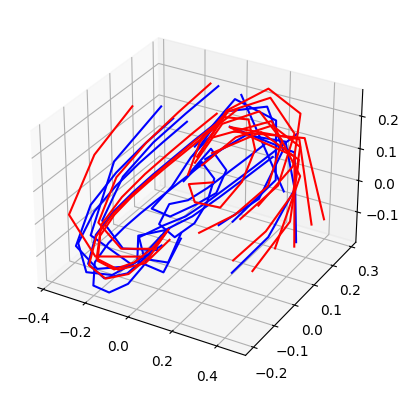

In [99]:
# Lagged residual trajectories.
radius = 0.3
sensor_index = 3
nom_trajectories = extract_trajectories(lag_res_flow[:,sensor_index,:], radius, min_traj_length=2, t_index=None, norm_traj=True)
fault_trajectories = extract_trajectories(lag_fault_res_flow[:,sensor_index,:], radius, min_traj_length=2, t_index=None, norm_traj=True)

ax = plt.figure().add_subplot(projection='3d')
for traj in nom_trajectories:
    ax.plot(traj[:,0], traj[:,1], traj[:,2], c='b')
    
for traj in fault_trajectories:
    ax.plot(traj[:,0], traj[:,1], traj[:,2], c='r')

<IPython.core.display.Javascript object>


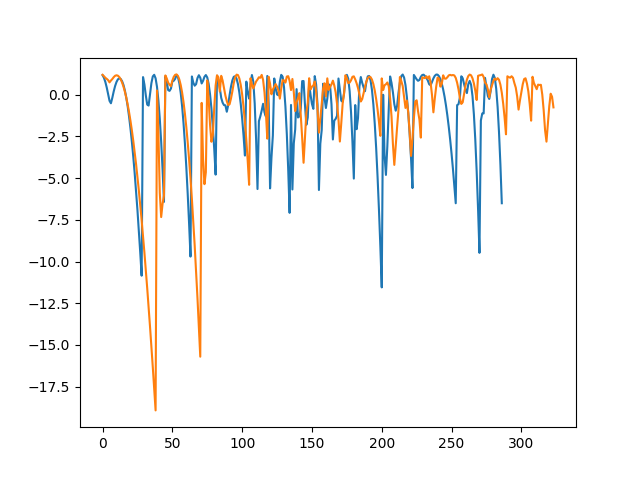

In [519]:
# Train one-class SVM.
sensor_idx = 3

# Stack trajectories.
nom_stack = nom_trajectories[0][:,:-1]
for i in range(1,len(nom_trajectories)):
    nom_stack = np.row_stack((nom_stack, nom_trajectories[i][:,:-1]))
    
fault_stack = fault_trajectories[0][:,:-1]
for i in range(1,len(fault_trajectories)):
    fault_stack = np.row_stack((fault_stack, fault_trajectories[i][:,:-1]))

# Support of nominal data.
clf = OneClassSVM(gamma='auto').fit(nom_stack)

# Re-predict on nomial data.
nom_pred = clf.predict(nom_stack)
nom_dist = clf.decision_function(nom_stack)

# Predict on fault data.
fault_pred = clf.predict(fault_stack)
fault_dist = clf.decision_function(fault_stack)

fig, ax = plt.subplots()
ax.plot(nom_dist)
ax.plot(fault_dist)

### Ensemble code

In [ ]:
# Run ensembled precip through model and compute residuals with measured state variables.
mod_depth = np.zeros((len(meas_depth), Nens, len(sensor_links)))
mod_velocity = np.zeros_like(mod_depth)
mod_flow = np.zeros_like(mod_depth)
mod_prcp = np.zeros((mod_depth.shape[0], mod_depth.shape[1]))
for i in range(Nens):
    # Single precip time series from ensemble.
    ens_prcp = ensemble_prcp[:,i]
    
    # Add precip to model.
    ts_name = 'Ensemble'
    ts_description = 'Ensemble Prcp.'
    raingage_id = 1
    swmm.add_prcp_timeseries(ts_name, ts_description, phy_time, ens_prcp, dates=phy_date, overwrite=True)
    swmm.set_raingage_timeseries(raingage_id, ts_name)
    
    # Run the model.
    swmm.run_simulation()

    # Get link depth.
    link_depth_df = swmm.get_link_depth()

    # Get link velocity.
    link_velocity_df = swmm.get_link_velocity()
    
    # Get link flow.
    link_flow_df = swmm.get_link_flow()
    
    # Extract the state variables at sensor locations.
    mod_depth[:,i,:] = link_depth_df.loc[:,[f'Depth_link_{j}' for j in sensor_links]].to_numpy()
    mod_velocity[:,i,:] = link_velocity_df.loc[:,[f'Velocity_link_{j}' for j in sensor_links]].to_numpy()
    mod_flow[:,i,:] = link_flow_df.loc[:,[f'Flow_link_{j}' for j in sensor_links]].to_numpy()
    
    # Precipitation used to drive the model.
    mod_prcp_df = swmm.get_rainfall_timeseries()
    mod_prcp[:,i] = mod_prcp_df['prcp'].to_numpy()

In [ ]:
# Depth residuals.
res_depth = np.zeros_like(mod_depth)
res_velocity = np.zeros_like(mod_depth)
res_flow = np.zeros_like(mod_depth)
for i in range(Nens):
    res_depth[:,i,:] = mod_depth[:,i,:] - meas_depth
    res_velocity[:,i,:] = mod_velocity[:,i,:] - meas_velocity
    res_flow[:,i,:] = mod_flow[:,i,:] - meas_flow

In [ ]:
# Depth residuals.
fault_res_depth = np.zeros_like(mod_depth)
fault_res_velocity = np.zeros_like(mod_depth)
fault_res_flow = np.zeros_like(mod_depth)
for i in range(Nens):
    fault_res_depth[:,i,:] = mod_depth[:,i,:] - fault_meas_depth
    fault_res_velocity[:,i,:] = mod_velocity[:,i,:] - fault_meas_velocity
    fault_res_flow[:,i,:] = mod_flow[:,i,:] - fault_meas_flow

In [ ]:
nom_res_1 = np.mean(res_flow[:,:,0], axis=1)
nom_res_2 = np.mean(res_flow[:,:,1], axis=1)
nom_res_3 = np.mean(res_flow[:,:,2], axis=1)
nom_res_4 = np.mean(res_flow[:,:,3], axis=1)
fault_res_1 = np.mean(fault_res_flow[:,:,0], axis=1)
fault_res_2 = np.mean(fault_res_flow[:,:,1], axis=1)
fault_res_3 = np.mean(fault_res_flow[:,:,2], axis=1)
fault_res_4 = np.mean(fault_res_flow[:,:,3], axis=1)

tau = 3
plot_df = pd.DataFrame({
    'res_t1': np.concatenate((nom_res_4[:-2 * tau], fault_res_4[:-2 * tau])),
    'res_t2': np.concatenate((nom_res_4[tau:-tau], fault_res_4[tau:-tau])),
    'res_t3': np.concatenate((nom_res_4[2 * tau:], fault_res_4[2 * tau:])),
    'state': np.concatenate((np.zeros(nom_res_4[:-2 * tau].shape), np.ones(nom_res_4[:-2 * tau].shape)))
})
fig = px.line_3d(plot_df, x='res_t1', y='res_t2', z='res_t3', color='state')
fig.show()

In [ ]:
# Create forcing ensemble from measured precip.
Nens = 30
ens_sig = 0.5

ensemble_prcp = np.zeros((len(meas_prcp), Nens))
for i in range(Nens):
    ens_noise = np.random.normal(0, ens_sig, len(meas_prcp)) * meas_prcp
    ens_prcp = meas_prcp + ens_noise
    ens_prcp[ens_prcp < 0] = 0.0
    ensemble_prcp[:,i] = ens_prcp